In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

In [12]:
#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = datasets.FashionMNIST('./data/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('./data/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/F_MNIST_data/FashionMNIST/raw



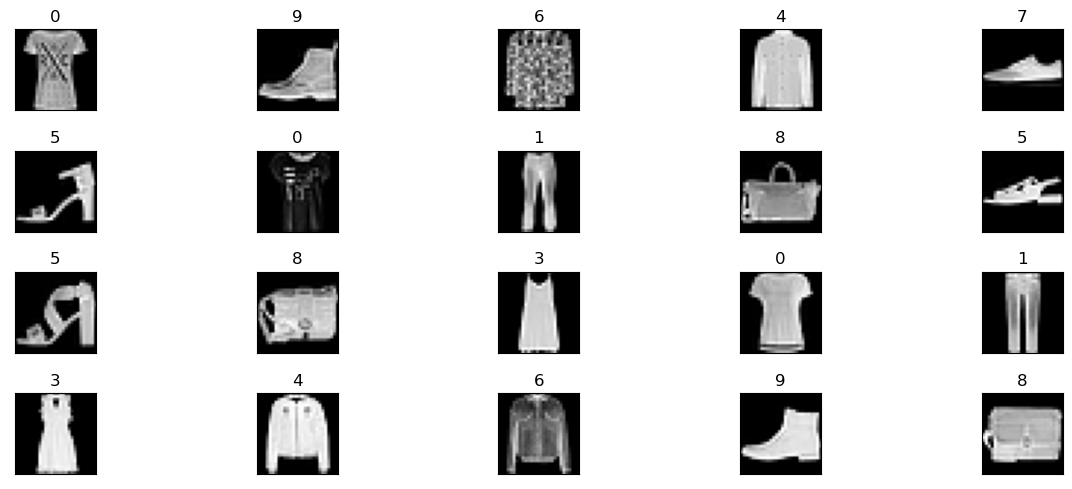

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
images, labels = dataiter._next_data()


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [45]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                # 28 x 28
                nn.Conv2d(1, 4, kernel_size=7),
                # 4 x 22 x 22
                nn.ReLU(True),
                nn.Conv2d(4, 8, kernel_size=7),
                nn.ReLU(True),
                # 8 x 16 x 16 = 3200
                nn.Flatten(),
                nn.Linear(2048, 15),
                # 15
                nn.Softmax(),
        )
        # self.decoder = nn.Sequential(
        #     # 15
        #     nn.Linear(15, 400),
        #     # 400
        #     nn.ReLU(True),
        #     nn.Linear(400, 4000),
        #     # 4000
        #     nn.ReLU(True),
        #     nn.Unflatten(1, (10, 20, 20)),
        #     # 10 x 20 x 20
        #     nn.ConvTranspose2d(10, 10, kernel_size=5),
        #     # 24 x 24
        #     nn.ConvTranspose2d(10, 1, kernel_size=5),
        #     # 28 x 28
        #     nn.Sigmoid(),
        #     )
        self.decoder = nn.Sequential(
                # 15
                nn.Linear(15, 2048),
                # 2048
                nn.ReLU(True),
                nn.Unflatten(1, (8, 16, 16)),
                # 8 x 16 x 16
                nn.ConvTranspose2d(8, 4, kernel_size=7),
                # 24 x 24
                nn.ConvTranspose2d(4, 1, kernel_size=7),
                # 28 x 28
                nn.Sigmoid(),
        )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec
      
    

In [49]:
class AutoencoderV2(nn.Module):
    def __init__(self):
        super(AutoencoderV2, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x


In [61]:
import os
from torch.autograd import Variable
from torchvision.utils import save_image

NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoencoderV2().to(device)
# distance = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './data/FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))
    
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        # if epoch % 5 == 0:
        #     save_decoded_image(outputs.cpu().data, epoch)
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

cpu
Epoch 1 of 50, Train Loss: 0.662
Epoch 2 of 50, Train Loss: 0.641
Epoch 3 of 50, Train Loss: 0.632
Epoch 4 of 50, Train Loss: 0.628
Epoch 5 of 50, Train Loss: 0.625
Epoch 6 of 50, Train Loss: 0.623
Epoch 7 of 50, Train Loss: 0.622
Epoch 8 of 50, Train Loss: 0.620
Epoch 9 of 50, Train Loss: 0.620
Epoch 10 of 50, Train Loss: 0.619
Epoch 11 of 50, Train Loss: 0.618
Epoch 12 of 50, Train Loss: 0.618
Epoch 13 of 50, Train Loss: 0.617
Epoch 14 of 50, Train Loss: 0.616
Epoch 15 of 50, Train Loss: 0.616
Epoch 16 of 50, Train Loss: 0.616
Epoch 17 of 50, Train Loss: 0.616
Epoch 18 of 50, Train Loss: 0.615
Epoch 19 of 50, Train Loss: 0.615
Epoch 20 of 50, Train Loss: 0.614
Epoch 21 of 50, Train Loss: 0.614
Epoch 22 of 50, Train Loss: 0.614
Epoch 23 of 50, Train Loss: 0.614
Epoch 24 of 50, Train Loss: 0.614
Epoch 25 of 50, Train Loss: 0.613
Epoch 26 of 50, Train Loss: 0.613
Epoch 27 of 50, Train Loss: 0.612
Epoch 28 of 50, Train Loss: 0.612
Epoch 29 of 50, Train Loss: 0.611
Epoch 30 of 50, Tra

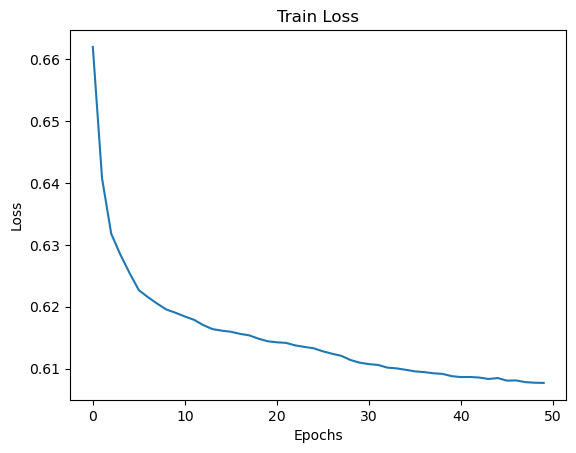

In [62]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
model.to(device)
make_dir()
# train the network
train_loss = train(model, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
# test the network
test_image_reconstruction(model, testloader)

tensor([[0.0685, 0.0686, 0.0678, 0.0596, 0.0715, 0.0698, 0.0748, 0.0685, 0.0648,
         0.0596, 0.0696, 0.0647, 0.0686, 0.0675, 0.0560],
        [0.0670, 0.0675, 0.0654, 0.0637, 0.0694, 0.0650, 0.0805, 0.0650, 0.0612,
         0.0631, 0.0664, 0.0642, 0.0671, 0.0706, 0.0640],
        [0.0653, 0.0679, 0.0664, 0.0602, 0.0764, 0.0670, 0.0868, 0.0640, 0.0585,
         0.0637, 0.0691, 0.0594, 0.0690, 0.0668, 0.0595],
        [0.0700, 0.0720, 0.0604, 0.0591, 0.0650, 0.0705, 0.0826, 0.0672, 0.0618,
         0.0580, 0.0708, 0.0603, 0.0687, 0.0727, 0.0610],
        [0.0721, 0.0693, 0.0671, 0.0621, 0.0679, 0.0638, 0.0828, 0.0665, 0.0631,
         0.0562, 0.0684, 0.0613, 0.0648, 0.0712, 0.0635],
        [0.0695, 0.0653, 0.0662, 0.0618, 0.0679, 0.0652, 0.0751, 0.0691, 0.0630,
         0.0623, 0.0682, 0.0679, 0.0658, 0.0678, 0.0648],
        [0.0692, 0.0674, 0.0679, 0.0664, 0.0732, 0.0660, 0.0809, 0.0624, 0.0567,
         0.0606, 0.0724, 0.0627, 0.0682, 0.0648, 0.0612],
        [0.0682, 0.0684, 0.

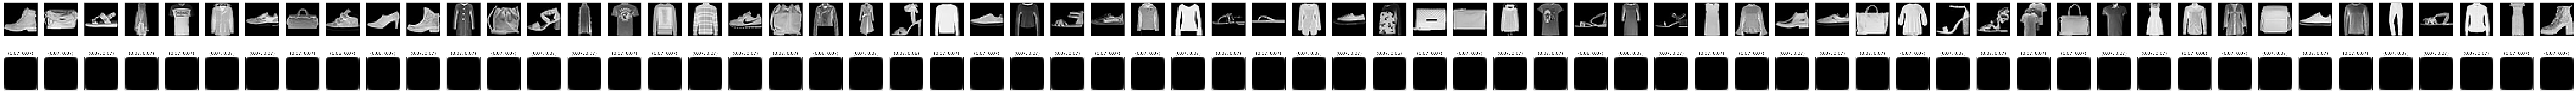

In [40]:
# def get_triple(inputs):
#     model.eval()
#     with torch.no_grad():
#         latent_repr = model.encoder(inputs)
#         print(latent_repr)
#         outputs = model.decoder(latent_repr)
#         latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))
#     return inputs, latent_repr, outputs

# def show_encodings(inputs, latent_repr, outputs):
#     n = len(inputs)
#     fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
#     for i in range(n):
#         axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
#         axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
#         axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
#     for ax in axes.flatten():
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

        
# for test_data in testloader:
#     img, _ = test_data
#     img = Variable(img).cpu()
#     show_encodings(*get_triple(img))
#     break